In [1]:
# loader
pip3 install tqdm
pip3 install numpy
pip3 install scipy
pip3 install sklearn
# main
pip3 install torch_sparse
pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu 
pip3 install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html
pip3 install matplotlib

SyntaxError: invalid syntax (1750817622.py, line 2)

Add some library 

In [2]:
import os.path as osp
import argparse
import time
from tqdm import tqdm
import copy as cp

import torch
import torch.nn.functional as F
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GCNConv
from torch.utils.data import random_split
from torch_geometric.datasets import upfd
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

from loader import *


model

model using GCN Convolution layer, with paper links: https://arxiv.org/pdf/1609.02907.pdf

In [3]:
class Model(torch.nn.Module):
	def __init__(self, args, concat=False):
		super(Model, self).__init__()
		self.args = args
		self.num_features = args.num_features
		self.nhid = args.nhid
		self.num_classes = args.num_classes
		self.dropout_ratio = args.dropout_ratio
		self.concat = concat
		self.conv1 = GCNConv(self.num_features, self.nhid)

		if self.concat:
			self.lin0 = torch.nn.Linear(self.num_features, self.nhid)
			self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)

		self.lin2 = torch.nn.Linear(self.nhid, self.num_classes)

	def forward(self, data):

		x, edge_index, batch = data.x, data.edge_index, data.batch

		edge_attr = None

		x = F.relu(self.conv1(x, edge_index, edge_attr))
		x = gmp(x, batch)

		if self.concat:
			news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
			news = F.relu(self.lin0(news))
			x = torch.cat([x, news], dim=1)
			x = F.relu(self.lin1(x))

		x = F.log_softmax(self.lin2(x), dim=-1)

		return x

test case

In [4]:
@torch.no_grad()
def compute_test(loader, verbose=False, data_visualize = False):
	model.eval()
	loss_test = 0.0
	out_log = []
	for data in loader:
		# if not args.multi_gpu:
		# 	data = data.to(args.device)
		out = model(data)
		# if args.multi_gpu:
		# 	y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		# else:
		y = data.y
		if verbose:
			print(F.softmax(out, dim=1).cpu().numpy())
		out_log.append([F.softmax(out, dim=1), y])
		loss_test += F.nll_loss(out, y).item()
	return eval_deep(out_log, loader, data_visualize), loss_test

variable component that used in this model

In [5]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=1000, help='random seed')
# parser.add_argument('--device', type=str, default='cuda:0', help='specify cuda devices')

# hyper-parameters
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
parser.add_argument('--dataset', type=str, default='politifact', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.01, help='weight decay')
parser.add_argument('--nhid', type=int, default=128, help='hidden size')
parser.add_argument('--dropout_ratio', type=float, default=0.1, help='dropout ratio')
parser.add_argument('--epochs', type=int, default=35, help='maximum number of epochs')
parser.add_argument('--concat', type=bool, default=True, help='whether concat news embedding and graph embedding')
# parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='bert', help='feature type, [profile, spacy, bert, content]')
# parser.add_argument('--model', type=str, default='gcn', help='model type, [gcn, gat, sage]')

args = parser.parse_args()

adding dataset to train and validate model and seed generation

citation to upfd dataset:
<strong data-cite="granger2013">(Granger, 2013)</strong>

In [6]:
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)


# path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'UPFD')
dataset = upfd.UPFD(root='data', feature=args.feature, split='train', name=args.dataset, transform=ToUndirected())

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

print(args)

Namespace(batch_size=128, concat=True, dataset='politifact', dropout_ratio=0.1, epochs=35, feature='bert', fff='/home/amar/.local/share/jupyter/runtime/kernel-5d6a4869-3114-4cb4-a06f-1cdb6c58c199.json', lr=0.001, nhid=128, num_classes=2, num_features=768, seed=1000, weight_decay=0.01)


adding dataset to test model and seed generation

In [7]:
test_dataset = upfd.UPFD(root='data', feature=args.feature, split='test', name=args.dataset, transform=ToUndirected())

args.num_classes_test = test_dataset.num_classes
args.num_features_test = test_dataset.num_features

print(args)

Namespace(batch_size=128, concat=True, dataset='politifact', dropout_ratio=0.1, epochs=35, feature='bert', fff='/home/amar/.local/share/jupyter/runtime/kernel-5d6a4869-3114-4cb4-a06f-1cdb6c58c199.json', lr=0.001, nhid=128, num_classes=2, num_classes_test=2, num_features=768, num_features_test=768, seed=1000, weight_decay=0.01)


divide dataset into 2: validate and training set

In [13]:
num_training = int(len(dataset) * 0.8) + 1
num_val = int(len(dataset) * 0.2)
training_set, validation_set = random_split(dataset, [num_training, num_val])
test_set = random_split(test_dataset, [len(test_dataset)])


load dataset 

In [14]:
# if args.multi_gpu:
# 	loader = DataListLoader
# else:
loader = DataLoader

train_loader = loader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = loader(validation_set, batch_size=args.batch_size, shuffle=False)
test_loader = loader(test_set[0], batch_size=args.batch_size, shuffle=False)

model = Model(args, concat=args.concat)
# if args.multi_gpu:
# 	model = DataParallel(model)
# model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay, eps=0.0000000001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00215,weight_decay=0.01)

validating and test model

100%|██████████| 35/35 [00:04<00:00,  7.25it/s]


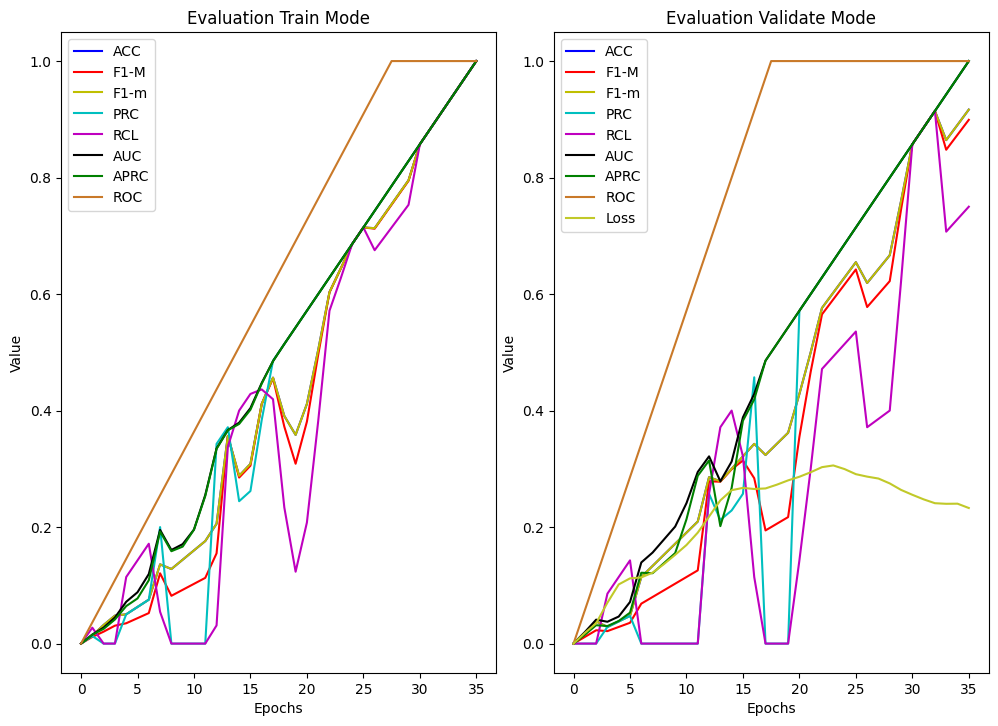

In [15]:
labels = [[0,'b','ACC'],[1,'r','F1-M'],[2,'y','F1-m'],[3,'c','PRC'],[4,'m','RCL'],[5,'k','AUC'],[6,'g','APRC'],[7,'#c97929','ROC'],[9,'#c1c929','Loss']]
if __name__ == '__main__':
	model.train()
	# accs_t, f1_macros_t, f1_micros_t, precisions_t, recalls_t, aucs_t, aps_t, fprs_t, tprs_t
	trains_dt = [[0], [0], [0], [0], [0], [0], [0], [], []]
	# accs_v, f1_macros_v, f1_micros_v, precisions_v, recalls_v, aucs_v, aps_v, fprs_v, tprs_v, losss_val  
	values_dt = [[0], [0], [0], [0], [0], [0], [0], [], [], [0]]
	for epoch in tqdm(range(args.epochs)):
		loss_train = 0.0
		out_log = []
		for i, data in enumerate(train_loader):
			optimizer.zero_grad()
			# if not args.multi_gpu:
				# data = data.to(args.device)
			out = model(data)
			# if args.multi_gpu:
			# 	y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
			# else:
			y = data.y
			loss = F.nll_loss(out, y)
			loss.backward()
			optimizer.step()		
			loss_train += loss.item()
			out_log.append([F.softmax(out, dim=1), y])
		acc_t, f1_macro_t, f1_micro_t, precision_t, recall_t, auc_t, ap_t, fpr_t, tpr_t = eval_deep(out_log, train_loader)
		# accuracy_view, f1_macro_view, f1_micro_view, precision_view, recall_view = eval_deep(out_log, train_loader,True)
		[acc_v, f1_macro_v, f1_micro_v, precision_v, recall_v, auc_v, ap_v, fpr_v, tpr_v], loss_val = compute_test(val_loader)
		# print(f'loss_train: {loss_train:.4f}, acc_train: {acc_train:.4f},'
		# 	  f' recall_train: {recall_train:.4f}, auc_train: {auc_train:.4f},'
			#   f' loss_val: {loss_val:.4f}, acc_val: {acc_val:.4f},'
			#   f' recall_val: {recall_val:.4f}, auc_val: {auc_val:.4f}')
		trains_dt[0].append(acc_t)
		trains_dt[1].append(f1_macro_t)
		trains_dt[2].append(f1_micro_t)
		trains_dt[3].append(precision_t)
		trains_dt[4].append(recall_t)
		trains_dt[5].append(auc_t)
		trains_dt[6].append(ap_t)
		trains_dt[7].extend(fpr_t)
		trains_dt[8].extend(tpr_t)

		values_dt[0].append(acc_v)
		values_dt[1].append(f1_macro_v)
		values_dt[2].append(f1_micro_v)
		values_dt[3].append(precision_v)
		values_dt[4].append(recall_v)
		values_dt[5].append(auc_v)
		values_dt[6].append(ap_v)
		values_dt[7].extend(fpr_v)
		values_dt[8].extend(tpr_v)
		values_dt[9].append(loss_val)

	trains_dt[0] = [x*float(i)/float(args.epochs) for i,x in enumerate(trains_dt[0])]
	trains_dt[1] = [x*float(i)/float(args.epochs) for i,x in enumerate(trains_dt[1])]
	trains_dt[2] = [x*float(i)/float(args.epochs) for i,x in enumerate(trains_dt[2])]
	trains_dt[3] = [x*float(i)/float(args.epochs) for i,x in enumerate(trains_dt[3])]
	trains_dt[4] = [x*float(i)/float(args.epochs) for i,x in enumerate(trains_dt[4])]
	trains_dt[5] = [x*float(i)/float(args.epochs) for i,x in enumerate(trains_dt[5])]
	trains_dt[6] = [x*float(i)/float(args.epochs) for i,x in enumerate(trains_dt[6])]

	values_dt[0] = [x*float(i)/float(args.epochs) for i,x in enumerate(values_dt[0])]
	values_dt[1] = [x*float(i)/float(args.epochs) for i,x in enumerate(values_dt[1])]
	values_dt[2] = [x*float(i)/float(args.epochs) for i,x in enumerate(values_dt[2])]
	values_dt[3] = [x*float(i)/float(args.epochs) for i,x in enumerate(values_dt[3])]
	values_dt[4] = [x*float(i)/float(args.epochs) for i,x in enumerate(values_dt[4])]
	values_dt[5] = [x*float(i)/float(args.epochs) for i,x in enumerate(values_dt[5])]
	values_dt[6] = [x*float(i)/float(args.epochs) for i,x in enumerate(values_dt[6])]
	values_dt[9] = [x*float(i)/float(args.epochs) for i,x in enumerate(values_dt[9])]
	
	ranges = [*range(args.epochs+1)]
	trains_dt[7] = np.unique([i*args.epochs for i in trains_dt[7]])
	# trains_dt[7] = np.sort(np.unique([i for i in trains_dt[7]]))
	if len(trains_dt[7]) <= args.epochs+1:
		trains_dt[7] = np.hstack([trains_dt[7],[trains_dt[7][-1]]*(args.epochs - len(trains_dt[7]) +1)])
	trains_dt[8] = np.unique([i for i in trains_dt[8]])
	if len(trains_dt[8]) <= args.epochs+1:
		trains_dt[8] = np.hstack([trains_dt[8],[trains_dt[8][-1]]*(args.epochs - len(trains_dt[8]) +1)])
	fig, ax = plt.subplots(1, 2, figsize=(10,7))
	fig.tight_layout()
	for c in labels:
		if c[0] < 7:
			ax[0].plot(ranges,trains_dt[c[0]],c[1],label=c[2])
		else:
			if c[0] >= 8:
				continue
			else:
				ax[0].plot(trains_dt[c[0]],trains_dt[c[0]+1],c[1],label=c[2])
	ax[0].set_title('Evaluation Train Mode')
	ax[0].set_xlabel('Epochs')
	ax[0].set_ylabel('Value')
	ax[0].legend()

	values_dt[7] = np.unique([i*args.epochs for i in values_dt[7]])
	# values_dt[7] = np.sort(np.unique([i for i in values_dt[7]]))
	if len(values_dt[7]) <= args.epochs+1:
		values_dt[7] = np.hstack([values_dt[7],[values_dt[7][-1]]*(args.epochs - len(values_dt[7]) +1)])
	values_dt[8] = np.unique([i for i in values_dt[8]])
	if len(values_dt[8]) <= args.epochs+1:
		values_dt[8] = np.hstack([values_dt[8],[values_dt[8][-1]]*(args.epochs - len(values_dt[8]) +1)])
	for c in labels:
		if c[0] == 7:
			ax[1].plot(values_dt[c[0]],values_dt[c[0]+1],c[1],label=c[2])
		else:
			ax[1].plot(ranges,values_dt[c[0]],c[1],label=c[2])
	ax[1].set_title('Evaluation Validate Mode')
	ax[1].set_xlabel('Epochs')
	ax[1].set_ylabel('Value')
	ax[1].legend()

In [16]:
[acc, f1_macro, f1_micro, precision, recall, auc, ap, fpr, tpr], test_loss = compute_test(test_loader, verbose=False)
print(f'Test set results: acc: {acc:.4f}, f1_macro: {f1_macro:.4f}, f1_micro: {f1_micro:.4f},'
        f'precision: {precision:.4f}, recall: {recall:.4f}, auc: {auc:.4f}, ap: {ap:.4f}, test_loss: {test_loss:.4f}')

# print(f'Test Loss: {test_loss: .4f}')
# plt.subplot(313)
# plt.title('Evaluation Train Mode')
# plt.xlabel('Epochs')
# plt.ylabel('Value')
# for c in labels:
#         if c[0] < 9:
#                 plt.plot(trains_dt[c[0]],ranges,c[1],label=c[2])



Test set results: acc: 0.8009, f1_macro: 0.7994, f1_micro: 0.8009,precision: 0.8700, recall: 0.7155, auc: 0.8865, ap: 0.8839, test_loss: 0.8780
